In [2]:
require(caret)
require(ggplot2)
require(data.table)
require(caTools)
library(parallel)
library(doParallel)
library(randomForest)
library(lubridate)

## Data Manipulation

In [2]:
options(repr.matrix.max.cols=50, repr.matrix.max.rows=100)

In [3]:
path="C:/Users/bahad/R Notebooks/"
bulk_imbalance = fread(sprintf("%sbulk_imbalance.csv", path))
data = bulk_imbalance
data = data[order(date,hour)]
data[,ID := 1:.N]
head(data)

date,hour,net,upRegulationZeroCoded,upRegulationOneCoded,upRegulationTwoCoded,downRegulationZeroCoded,downRegulationOneCoded,downRegulationTwoCoded,upRegulationDelivered,downRegulationDelivered,system_direction,ID
2019-01-01,0,-1934.795,0,0,0,2288.567,0,0,0,-1934.795,Negative,1
2019-01-01,1,-750.866,0,0,0,808.083,0,0,0,-750.866,Negative,2
2019-01-01,2,-982.767,0,0,0,1060.750,0,0,0,-982.767,Negative,3
2019-01-01,3,-764.620,0,0,0,1120.483,0,0,0,-764.620,Negative,4
2019-01-01,4,-1233.289,0,0,0,1874.633,56,0,0,-1233.289,Negative,5
2019-01-01,5,-1469.061,0,0,0,2125.000,56,0,0,-1469.061,Negative,6


In [4]:
current_date="2022-01-22"

features=fread(sprintf("%s%s_weather/%s_weather.csv",path, current_date, current_date))

wide_feat = dcast(features, date + hour ~ variable+ lat + lon , value.var="value")

tail(wide_feat)

date,hour,DSWRF_surface_36.5_32.5,DSWRF_surface_37_35.5,DSWRF_surface_38_32.5,DSWRF_surface_38.5_27,DSWRF_surface_39.75_30.5,DSWRF_surface_40_33,DSWRF_surface_41_28.75,RH_2.m.above.ground_36.5_32.5,RH_2.m.above.ground_37_35.5,RH_2.m.above.ground_38_32.5,RH_2.m.above.ground_38.5_27,RH_2.m.above.ground_39.75_30.5,RH_2.m.above.ground_40_33,RH_2.m.above.ground_41_28.75,TCDC_low.cloud.layer_36.5_32.5,TCDC_low.cloud.layer_37_35.5,TCDC_low.cloud.layer_38_32.5,TCDC_low.cloud.layer_38.5_27,TCDC_low.cloud.layer_39.75_30.5,TCDC_low.cloud.layer_40_33,TCDC_low.cloud.layer_41_28.75,TMP_2.m.above.ground_36.5_32.5,TMP_2.m.above.ground_37_35.5,TMP_2.m.above.ground_38_32.5,TMP_2.m.above.ground_38.5_27,TMP_2.m.above.ground_39.75_30.5,TMP_2.m.above.ground_40_33,TMP_2.m.above.ground_41_28.75,wdir_10m_36.5_32.5,wdir_10m_37_35.5,wdir_10m_38_32.5,wdir_10m_38.5_27,wdir_10m_39.75_30.5,wdir_10m_40_33,wdir_10m_41_28.75,ws_10m_36.5_32.5,ws_10m_37_35.5,ws_10m_38_32.5,ws_10m_38.5_27,ws_10m_39.75_30.5,ws_10m_40_33,ws_10m_41_28.75
2022-01-27,18,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2022-01-27,19,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2022-01-27,20,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2022-01-27,21,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2022-01-27,22,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2022-01-27,23,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


### Feature Adding

In [5]:
data[, lag_24:=shift(net, 24)]
data[, lag_168:=shift(net, 168)]
# data[, lag_6:=shift(net, 6)]
# data[, lag_7:=shift(net, 7)]
# data[, lag_8:=shift(net, 8)]
data <- data[seq(-168,-1),]

data$weekday=wday(data$date)
data[, is_monday:=ifelse(weekday==2, 1, 0)]
data[, is_wday:=ifelse(weekday%in%c(3,4,5), 1, 0)]
data[, is_friday:=ifelse(weekday==6, 1, 0)]
data[, is_saturday:=ifelse(weekday==7, 1, 0)]
data[, is_sunday:=ifelse(weekday==1, 1, 0)]

data[, is_over:=ifelse(hour%in% c(17,18,19,20) , 1, 0)]
data[, is_12:=ifelse(hour==12 , 1, 0)]
data[, is_13:=ifelse(hour==13 , 1, 0)]
data[, is_22:=ifelse(hour==22 , 1, 0)]
data[, is_23:=ifelse(hour==23 , 1, 0)]

In [6]:
head(data)

date,hour,net,upRegulationZeroCoded,upRegulationOneCoded,upRegulationTwoCoded,downRegulationZeroCoded,downRegulationOneCoded,downRegulationTwoCoded,upRegulationDelivered,downRegulationDelivered,system_direction,ID,lag_24,lag_168,weekday,is_monday,is_wday,is_friday,is_saturday,is_sunday,is_over,is_12,is_13,is_22,is_23
2019-01-08,0,-464.400,0.000,0,0,761.616,0,0,0.000,-464.400,Negative,169,-1176.657,-1934.795,3,0,1,0,0,0,0,0,0,0,0
2019-01-08,1,-8.662,245.833,0,0,259.067,0,0,206.833,-215.495,Neutral,170,-406.941,-750.866,3,0,1,0,0,0,0,0,0,0,0
2019-01-08,2,70.445,274.748,0,0,17.100,0,0,85.145,-14.700,Positive,171,-403.687,-982.767,3,0,1,0,0,0,0,0,0,0,0
2019-01-08,3,60.549,352.000,0,0,0.000,0,0,60.549,0.000,Positive,172,-579.674,-764.620,3,0,1,0,0,0,0,0,0,0,0
2019-01-08,4,43.140,352.000,0,0,0.000,0,0,43.140,0.000,Neutral,173,467.443,-1233.289,3,0,1,0,0,0,0,0,0,0,0
2019-01-08,5,25.490,212.000,0,0,0.000,0,0,25.490,0.000,Neutral,174,391.953,-1469.061,3,0,1,0,0,0,0,0,0,0,0


### Selecting Available Features

In [7]:
data = data[,!c("V1","upRegulationZeroCoded","upRegulationOneCoded","upRegulationTwoCoded",
                "downRegulationZeroCoded","downRegulationOneCoded","downRegulationTwoCoded",
                 "upRegulationDelivered","downRegulationDelivered")] 
str(data)

Warning message in `[.data.table`(data, , !c("V1", "upRegulationZeroCoded", "upRegulationOneCoded", :
"column(s) not removed because not found: [V1]"

Classes 'data.table' and 'data.frame':	26496 obs. of  18 variables:
 $ date            : IDate, format: "2019-01-08" "2019-01-08" ...
 $ hour            : int  0 1 2 3 4 5 6 7 8 9 ...
 $ net             : num  -464.4 -8.66 70.44 60.55 43.14 ...
 $ system_direction: chr  "Negative" "Neutral" "Positive" "Positive" ...
 $ ID              : int  169 170 171 172 173 174 175 176 177 178 ...
 $ lag_24          : num  -1177 -407 -404 -580 467 ...
 $ lag_168         : num  -1935 -751 -983 -765 -1233 ...
 $ weekday         : num  3 3 3 3 3 3 3 3 3 3 ...
 $ is_monday       : num  0 0 0 0 0 0 0 0 0 0 ...
 $ is_wday         : num  1 1 1 1 1 1 1 1 1 1 ...
 $ is_friday       : num  0 0 0 0 0 0 0 0 0 0 ...
 $ is_saturday     : num  0 0 0 0 0 0 0 0 0 0 ...
 $ is_sunday       : num  0 0 0 0 0 0 0 0 0 0 ...
 $ is_over         : num  0 0 0 0 0 0 0 0 0 0 ...
 $ is_12           : num  0 0 0 0 0 0 0 0 0 0 ...
 $ is_13           : num  0 0 0 0 0 0 0 0 0 0 ...
 $ is_22           : num  0 0 0 0 0 0 0 0 0 0 ...


# Sax Represenation with Cut Function

In [8]:
test_start="2021-12-01"
test_finish="2021-12-14"

In [9]:
data <- data[date<=test_finish,]

## Labels

In [10]:
alphabet_size=10

data[,net_new := cut(net, quantile(net, probs = 0:alphabet_size/alphabet_size),
                              labels = FALSE, include.lowest = TRUE)]
summary(data)

      date                 hour            net          system_direction  
 Min.   :2019-01-08   Min.   : 0.00   Min.   :-5229.3   Length:25728      
 1st Qu.:2019-10-02   1st Qu.: 5.75   1st Qu.: -290.5   Class :character  
 Median :2020-06-26   Median :11.50   Median :  175.5   Mode  :character  
 Mean   :2020-06-26   Mean   :11.50   Mean   :  274.2                     
 3rd Qu.:2021-03-21   3rd Qu.:17.25   3rd Qu.:  782.5                     
 Max.   :2021-12-14   Max.   :23.00   Max.   : 9609.1                     
       ID            lag_24           lag_168           weekday     
 Min.   :  169   Min.   :-5229.3   Min.   :-5229.3   Min.   :1.000  
 1st Qu.: 6601   1st Qu.: -291.2   1st Qu.: -302.5   1st Qu.:2.000  
 Median :13032   Median :  175.5   Median :  169.1   Median :4.000  
 Mean   :13032   Mean   :  274.6   Mean   :  267.6   Mean   :3.999  
 3rd Qu.:19464   3rd Qu.:  782.7   3rd Qu.:  778.9   3rd Qu.:6.000  
 Max.   :25896   Max.   : 9609.1   Max.   : 9609.1   Max.   :

## Label Update by considering actual Class Information

In [11]:
data$system_direction <- as.factor(data$system_direction) 

data$net_new <- as.factor(data$net_new) 

data[(net>(-50))& (net<50), ]$net_new=4

data$net_new <- as.factor(data$net_new) 

{1,2,3} represents Negative sets, {4} is selected for 0, and {5,6,7,8,9,10} are used to show positive cases. 1 & 10 includes outliers in the dataset. 

In [12]:
head(data)

date,hour,net,system_direction,ID,lag_24,lag_168,weekday,is_monday,is_wday,is_friday,is_saturday,is_sunday,is_over,is_12,is_13,is_22,is_23,net_new
2019-01-08,0,-464.400,Negative,169,-1176.657,-1934.795,3,0,1,0,0,0,0,0,0,0,0,2
2019-01-08,1,-8.662,Neutral,170,-406.941,-750.866,3,0,1,0,0,0,0,0,0,0,0,4
2019-01-08,2,70.445,Positive,171,-403.687,-982.767,3,0,1,0,0,0,0,0,0,0,0,5
2019-01-08,3,60.549,Positive,172,-579.674,-764.620,3,0,1,0,0,0,0,0,0,0,0,5
2019-01-08,4,43.140,Neutral,173,467.443,-1233.289,3,0,1,0,0,0,0,0,0,0,0,4
2019-01-08,5,25.490,Neutral,174,391.953,-1469.061,3,0,1,0,0,0,0,0,0,0,0,4


## Feature Adding

In [13]:
feat=fread("2022-01-22_weather.csv")

In [14]:
wide_feat=dcast(feat, date + hour ~ variable+ lat + lon , value.var="value")
wide_feat=wide_feat[date<Sys.Date(),]

In [15]:
str(wide_feat)

Classes 'data.table' and 'data.frame':	26880 obs. of  44 variables:
 $ date                           : IDate, format: "2018-12-31" "2018-12-31" ...
 $ hour                           : int  0 1 2 3 4 5 6 7 8 9 ...
 $ DSWRF_surface_36.5_32.5        : num  0 0 0 0 0 ...
 $ DSWRF_surface_37_35.5          : num  0 0 0 0 0 ...
 $ DSWRF_surface_38_32.5          : num  0 0 0 0 0 ...
 $ DSWRF_surface_38.5_27          : num  0 0 0 0 0 0 0 0 0 0 ...
 $ DSWRF_surface_39.75_30.5       : num  0 0 0 0 0 0 0 0 0 0 ...
 $ DSWRF_surface_40_33            : num  0 0 0 0 0 0 0 0 0 0 ...
 $ DSWRF_surface_41_28.75         : num  0 0 0 0 0 0 0 0 0 0 ...
 $ RH_2.m.above.ground_36.5_32.5  : num  83.3 82 80.7 79.4 78.8 ...
 $ RH_2.m.above.ground_37_35.5    : num  76.1 74.6 73.1 71.6 71.3 71 70.7 70.9 71.1 71.3 ...
 $ RH_2.m.above.ground_38_32.5    : num  93.2 92.9 92.7 92.4 92.1 ...
 $ RH_2.m.above.ground_38.5_27    : num  75.2 76 76.9 77.7 77.6 ...
 $ RH_2.m.above.ground_39.75_30.5 : num  88.7 88.5 88.4 88.2 8

# PCA

### DSWRF

In [16]:
str(wide_feat)

Classes 'data.table' and 'data.frame':	26880 obs. of  44 variables:
 $ date                           : IDate, format: "2018-12-31" "2018-12-31" ...
 $ hour                           : int  0 1 2 3 4 5 6 7 8 9 ...
 $ DSWRF_surface_36.5_32.5        : num  0 0 0 0 0 ...
 $ DSWRF_surface_37_35.5          : num  0 0 0 0 0 ...
 $ DSWRF_surface_38_32.5          : num  0 0 0 0 0 ...
 $ DSWRF_surface_38.5_27          : num  0 0 0 0 0 0 0 0 0 0 ...
 $ DSWRF_surface_39.75_30.5       : num  0 0 0 0 0 0 0 0 0 0 ...
 $ DSWRF_surface_40_33            : num  0 0 0 0 0 0 0 0 0 0 ...
 $ DSWRF_surface_41_28.75         : num  0 0 0 0 0 0 0 0 0 0 ...
 $ RH_2.m.above.ground_36.5_32.5  : num  83.3 82 80.7 79.4 78.8 ...
 $ RH_2.m.above.ground_37_35.5    : num  76.1 74.6 73.1 71.6 71.3 71 70.7 70.9 71.1 71.3 ...
 $ RH_2.m.above.ground_38_32.5    : num  93.2 92.9 92.7 92.4 92.1 ...
 $ RH_2.m.above.ground_38.5_27    : num  75.2 76 76.9 77.7 77.6 ...
 $ RH_2.m.above.ground_39.75_30.5 : num  88.7 88.5 88.4 88.2 8

In [17]:
pca_DSWRF=princomp(wide_feat[,seq(1:7)+2,with=F])
summary(pca_DSWRF,loadings=T)

Importance of components:
                            Comp.1     Comp.2       Comp.3       Comp.4
Standard deviation     698.6375896 91.9068787 70.626832627 56.342454516
Proportion of Variance   0.9529455  0.0164915  0.009738759  0.006197773
Cumulative Proportion    0.9529455  0.9694370  0.979175749  0.985373523
                             Comp.5       Comp.6       Comp.7
Standard deviation     51.822317537 50.568720451 47.422244122
Proportion of Variance  0.005243217  0.004992615  0.004390645
Cumulative Proportion   0.990616739  0.995609355  1.000000000

Loadings:
                         Comp.1 Comp.2 Comp.3 Comp.4 Comp.5 Comp.6 Comp.7
DSWRF_surface_36.5_32.5   0.403  0.385  0.426  0.131  0.234  0.648  0.123
DSWRF_surface_37_35.5     0.379  0.390  0.280 -0.601 -0.253 -0.446       
DSWRF_surface_38_32.5     0.389  0.291 -0.221  0.557  0.372 -0.516       
DSWRF_surface_38.5_27     0.378 -0.389  0.345  0.415 -0.586        -0.263
DSWRF_surface_39.75_30.5  0.370 -0.253 -0.371        -0.2

### RH_2.m.above

In [18]:
pca_RH=princomp(wide_feat[,seq(1:7)+9,with=F])
summary(pca_RH,loadings=T)

Importance of components:
                           Comp.1     Comp.2      Comp.3      Comp.4     Comp.5
Standard deviation     44.5869745 17.3207688 15.80892988 13.08547168 9.34503795
Proportion of Variance  0.6820781  0.1029325  0.08574782  0.05874851 0.02996265
Cumulative Proportion   0.6820781  0.7850106  0.87075843  0.92950694 0.95946959
                           Comp.6     Comp.7
Standard deviation     7.86807903 7.49826985
Proportion of Variance 0.02124005 0.01929036
Cumulative Proportion  0.98070964 1.00000000

Loadings:
                               Comp.1 Comp.2 Comp.3 Comp.4 Comp.5 Comp.6 Comp.7
RH_2.m.above.ground_36.5_32.5   0.418         0.779  0.284  0.345         0.128
RH_2.m.above.ground_37_35.5     0.359  0.892        -0.172 -0.193              
RH_2.m.above.ground_38_32.5     0.420 -0.333  0.211 -0.265 -0.539        -0.545
RH_2.m.above.ground_38.5_27     0.350        -0.306  0.675 -0.240 -0.515       
RH_2.m.above.ground_39.75_30.5  0.429 -0.109 -0.383 -0.242  0.6

### TCDC_low

In [19]:
pca_TCDC=princomp(wide_feat[,seq(1:7)+16,with=F])
summary(pca_TCDC,loadings=T)

Importance of components:
                           Comp.1     Comp.2     Comp.3      Comp.4      Comp.5
Standard deviation     58.1096267 32.3675786 27.1512582 22.73640511 21.70951712
Proportion of Variance  0.4883719  0.1515217  0.1066189  0.07476495  0.06816396
Cumulative Proportion   0.4883719  0.6398936  0.7465125  0.82127750  0.88944145
                            Comp.6      Comp.7
Standard deviation     20.50490703 18.54667120
Proportion of Variance  0.06080931  0.04974924
Cumulative Proportion   0.95025076  1.00000000

Loadings:
                                Comp.1 Comp.2 Comp.3 Comp.4 Comp.5 Comp.6
TCDC_low.cloud.layer_36.5_32.5   0.392  0.377  0.342  0.332  0.321       
TCDC_low.cloud.layer_37_35.5     0.290  0.459  0.425 -0.430 -0.545 -0.111
TCDC_low.cloud.layer_38_32.5     0.346  0.322 -0.176 -0.148  0.564  0.269
TCDC_low.cloud.layer_38.5_27     0.224 -0.166  0.236  0.732 -0.317  0.203
TCDC_low.cloud.layer_39.75_30.5  0.451 -0.167 -0.478 -0.162 -0.351  0.558
TCDC_low.cl

### TMP_2.m.above.ground

In [20]:
pca_TMP=princomp(wide_feat[,seq(1:7)+23,with=F])
summary(pca_TMP,loadings=T)

Importance of components:
                           Comp.1     Comp.2     Comp.3     Comp.4     Comp.5
Standard deviation     22.4644769 2.96560779 2.50402491 2.11736945 1.68558070
Proportion of Variance  0.9520682 0.01659216 0.01182913 0.00845802 0.00536012
Cumulative Proportion   0.9520682 0.96866036 0.98048949 0.98894751 0.99430763
                            Comp.6      Comp.7
Standard deviation     1.373985149 1.062760528
Proportion of Variance 0.003561554 0.002130818
Cumulative Proportion  0.997869182 1.000000000

Loadings:
                                Comp.1 Comp.2 Comp.3 Comp.4 Comp.5 Comp.6
TMP_2.m.above.ground_36.5_32.5   0.383  0.393  0.171  0.168  0.627  0.488
TMP_2.m.above.ground_37_35.5     0.384  0.608  0.370        -0.554 -0.179
TMP_2.m.above.ground_38_32.5     0.403        -0.439  0.293  0.224 -0.466
TMP_2.m.above.ground_38.5_27     0.369 -0.296  0.335 -0.661  0.313 -0.355
TMP_2.m.above.ground_39.75_30.5  0.391 -0.251 -0.296 -0.333 -0.331  0.607
TMP_2.m.above.groun

### w Values

In [21]:
pca_w=princomp(wide_feat[,seq(1:14)+30,with=F])
summary(pca_w,loadings=T)

Importance of components:
                            Comp.1      Comp.2     Comp.3     Comp.4     Comp.5
Standard deviation     129.5758022 111.7800382 92.1862191 85.4215184 81.9200746
Proportion of Variance   0.2695446   0.2005909  0.1364315  0.1171433  0.1077367
Cumulative Proportion    0.2695446   0.4701355  0.6065671  0.7237104  0.8314470
                            Comp.6      Comp.7       Comp.8       Comp.9
Standard deviation     75.63668587 68.93272795 3.4434155012 2.184001e+00
Proportion of Variance  0.09184336  0.07628405 0.0001903538 7.657529e-05
Cumulative Proportion   0.92329037  0.99957442 0.9997647738 9.998413e-01
                            Comp.10      Comp.11      Comp.12      Comp.13
Standard deviation     1.670075e+00 1.622508e+00 1.402831e+00 1.137171e+00
Proportion of Variance 4.477695e-05 4.226265e-05 3.159321e-05 2.076034e-05
Cumulative Proportion  9.998861e-01 9.999284e-01 9.999600e-01 9.999807e-01
                            Comp.14
Standard deviation     1.0

## New Feature Dataset

In [22]:
new_feat=data.table(date=wide_feat$date, hour=wide_feat$hour, DSWRF=pca_DSWRF$scores[,1], RH=pca_RH$scores[,1],
                    TCDC1 = pca_TCDC$scores[,1], TCDC2 = pca_TCDC$scores[, 2], TMP = pca_TMP$scores[, 1], w1 = pca_w$scores[,1],
                    w2 = pca_w$scores[,2], w3 = pca_w$scores[,3])

In [23]:
head(new_feat)

date,hour,DSWRF,RH,TCDC1,TCDC2,TMP,w1,w2,w3
2018-12-31,0,-569.9611,64.35230,48.643230,6.501146,-40.09289,81.52956,-73.72133,-23.73527
2018-12-31,1,-569.9611,63.22281,42.236239,6.855581,-40.50658,85.82155,-83.52298,-32.70480
2018-12-31,2,-569.9611,62.09332,35.829249,7.210017,-40.92027,90.11354,-93.32463,-41.67434
2018-12-31,3,-569.9611,60.96383,29.422258,7.564453,-41.33397,94.40553,-103.12628,-50.64387
2018-12-31,4,-569.9611,59.88503,13.947211,-2.686073,-42.00791,97.00861,-70.70537,-14.21063
2018-12-31,5,-569.9611,58.80623,-1.527836,-12.936599,-42.68185,99.61169,-38.28447,22.22261


In [24]:
all_dt=merge(x = data, y=new_feat, by=c("date", "hour"), all.x=TRUE)

In [25]:
head(all_dt)

date,hour,net,system_direction,ID,lag_24,lag_168,weekday,is_monday,is_wday,is_friday,is_saturday,is_sunday,is_over,is_12,is_13,is_22,is_23,net_new,DSWRF,RH,TCDC1,TCDC2,TMP,w1,w2,w3
2019-01-08,0,-464.400,Negative,169,-1176.657,-1934.795,3,0,1,0,0,0,0,0,0,0,0,2,-569.9611,61.86299,98.70077,30.45218,-42.44280,-19.35854,-126.337284,-125.995139
2019-01-08,1,-8.662,Neutral,170,-406.941,-750.866,3,0,1,0,0,0,0,0,0,0,0,4,-569.9611,62.38798,95.00830,31.00809,-42.51784,-26.14478,-69.761402,-65.321967
2019-01-08,2,70.445,Positive,171,-403.687,-982.767,3,0,1,0,0,0,0,0,0,0,0,5,-569.9611,62.91296,91.31583,31.56401,-42.59289,-32.93102,-13.185520,-4.648795
2019-01-08,3,60.549,Positive,172,-579.674,-764.620,3,0,1,0,0,0,0,0,0,0,0,5,-569.9611,63.43795,87.62336,32.11992,-42.66794,-39.71726,43.390362,56.024377
2019-01-08,4,43.140,Neutral,173,467.443,-1233.289,3,0,1,0,0,0,0,0,0,0,0,4,-569.9611,67.10149,86.17535,23.69623,-42.78473,-48.66498,20.914823,19.575963
2019-01-08,5,25.490,Neutral,174,391.953,-1469.061,3,0,1,0,0,0,0,0,0,0,0,4,-569.9611,70.76503,84.72734,15.27253,-42.90151,-57.61271,-1.560716,-16.872452


# Model

In [26]:
test_date_start="2021-12-01"
test_date_end="2021-12-14"

In [27]:
train=all_dt[date<test_date_start,]
test=all_dt[(date>=test_date_start) & (date<=test_date_end),]

In [28]:
train=train[,-c("date", "net", "system_direction", "ID", "is_over")]
test=test[,-c("date", "net", "system_direction", "ID", "is_over")]

## KNN Calculation

In [29]:
library(caret)

### Data Preparation

In [30]:
trainclass=train$net_new
traindata=as.matrix(train[, -c(14),with=F])

traindata=scale(traindata)
train=data.table(cl=trainclass,traindata)

### KNN Model

In [31]:
ctrl = trainControl(method="repeatedcv",repeats = 3,number=10) 
knnFit=train(cl ~ ., data = train, method = "knn", 
                trControl = ctrl, 
                tuneLength = 10)

In [32]:
knnFit

k-Nearest Neighbors 

25392 samples
   21 predictor
   10 classes: '1', '2', '3', '4', '5', '6', '7', '8', '9', '10' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 22853, 22854, 22855, 22853, 22852, 22853, ... 
Resampling results across tuning parameters:

  k   Accuracy   Kappa    
   5  0.2854041  0.2005847
   7  0.2758344  0.1894282
   9  0.2671039  0.1789953
  11  0.2600412  0.1706082
  13  0.2534774  0.1628068
  15  0.2489754  0.1573194
  17  0.2454577  0.1530646
  19  0.2438570  0.1509137
  21  0.2386575  0.1448077
  23  0.2374632  0.1431923

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was k = 5.

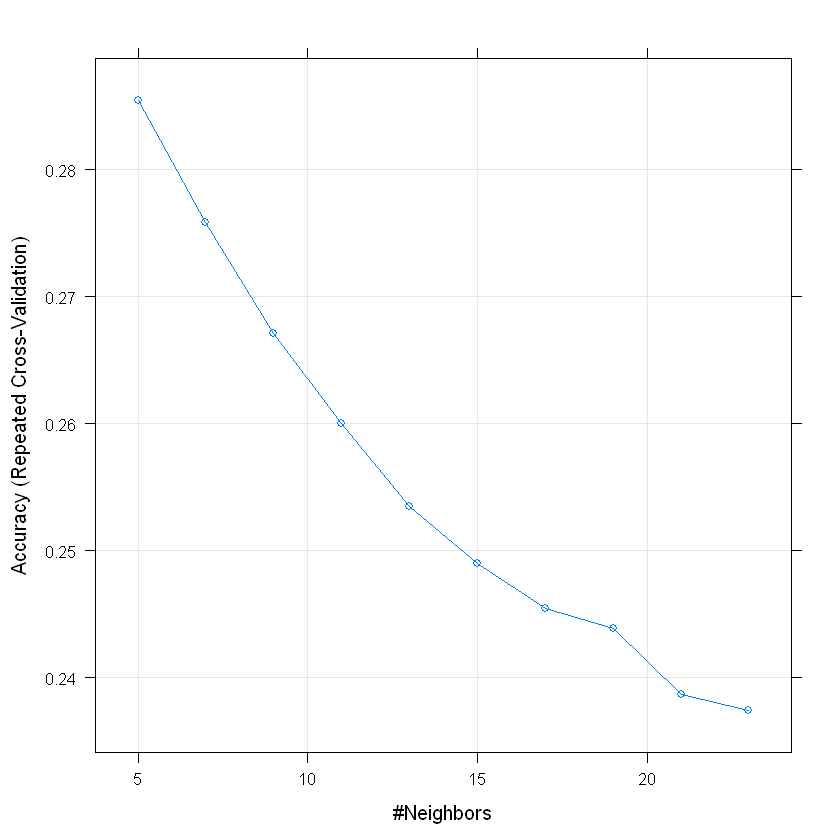

In [33]:
plot(knnFit)

# Predictions

In [34]:
testclass=test$net_new
testdata=as.matrix(test[, -c(14),with=F])

testdata=scale(testdata)
test=data.table(cl=testclass,testdata)

In [35]:
pred=predict(knnFit, test)

res_dt=data.table(actual=all_dt[(date>=test_date_start) & (date<=test_date_end),]$net_new, 
                  actual_req=all_dt[(date>=test_date_start) & (date<=test_date_end),]$system_direction, predicted=pred)

table(actual=res_dt$actual,  predicted=res_dt$predicted)

      predicted
actual  1  2  3  4  5  6  7  8  9 10
    1   0  3  0  1  0  0  1  1  2  1
    2   3  4  1  4  0  0  1  2  1  0
    3   3  5  1  8  1  3  0  0  4  2
    4   8  3  5  8  4  6  7  4  2  0
    5   3  3  8  2  1  1  2  4  0  1
    6   5  6  5  5  2  6  3  1  2  2
    7   1  2  9  6  2  6  2  2  3  2
    8   7  8  9  9  2  4  4  2  2  4
    9   5  5  5 12  2  5  5  5  4  3
    10  0  0  2  6  1  1  9  5  6  8

## Class Predictions

In [36]:
res_dt[, converted_pred:=ifelse(predicted %in% c("1","2", "3"), "Negative", 
                         ifelse(predicted %in% c("5","6","7","8","9","10"), "Positive", "Neutral"))]

table(actual=res_dt$actual_req,  predicted=res_dt$converted_pred)

          predicted
actual     Negative Neutral Positive
  Negative       28      15       27
  Neutral         8       6       15
  Positive       83      40      114

In [37]:
confusionMatrix(data = as.factor(res_dt$converted_pred), reference = as.factor(res_dt$actual_req), mode = "prec_recall")

Confusion Matrix and Statistics

          Reference
Prediction Negative Neutral Positive
  Negative       28       8       83
  Neutral        15       6       40
  Positive       27      15      114

Overall Statistics
                                          
               Accuracy : 0.4405          
                 95% CI : (0.3866, 0.4954)
    No Information Rate : 0.7054          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.0404          
                                          
 Mcnemar's Test P-Value : 4.006e-09       

Statistics by Class:

                     Class: Negative Class: Neutral Class: Positive
Precision                    0.23529        0.09836          0.7308
Recall                       0.40000        0.20690          0.4810
F1                           0.29630        0.13333          0.5802
Prevalence                   0.20833        0.08631          0.7054
Detection Rate               